In [1]:
# import the necessary libraries

import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

Preprocessing

In [2]:
house_data = pd.read_csv("dataset/kc_house_data.csv")
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
incident_data = pd.read_csv("dataset/KCSO_Incident_Dataset__Historic_to_2019.csv")
incident_data.head()

,case_number,incident_datetime,incident_type,FCR,address_1,city,state,zip,created_at,updated_at,hour_of_day,day_of_week,Incident Block Location
0,C19046940,12/09/2019 09:02:00 AM,Other,503,1 Block AVE & YESLER WAY,SEATTLE,WA,98104,12/12/2019 06:19:00 PM,12/12/2019 08:07:00 PM,9,Monday,NaN
1,C19046039,12/02/2019 06:01:00 PM,Other,162,19700 Block 635TH PL NE,BARING,WA,98224,12/05/2019 05:15:00 PM,12/05/2019 07:06:00 PM,18,Monday,NaN
2,C19026684,07/14/2019 01:29:00 AM,Vehicle Recovery,311,1 Block PL S & DES MOINES MEMORIAL DR S,BURIEN,WA,98168,07/15/2019 05:45:00 AM,07/15/2019 06:09:00 PM,1,Sunday,NaN
3,C19043968,11/16/2019 10:07:00 PM,Traffic,404,RAINIER AVE N & RENTON AVE S,SKYWAY,WA,98178,11/19/2019 04:30:00 PM,11/19/2019 06:16:00 PM,22,Saturday,NaN
4,C19042199,11/04/2019 07:18:00 AM,Property Crime,313,1 Block PL S & DES MOINES MEMORIAL DR S,BURIEN,WA,98168,11/05/2019 04:35:00 PM,11/05/2019 06:26:00 PM,7,Monday,NaN


In [4]:
# convert those with yr_renovated == 0 to yr_built before dropping the yr_renovated column

house_data["new_yr_renovated"] = [house_data.iloc[i]["yr_renovated"].item() if house_data.iloc[i]["yr_renovated"].item() > 0 else house_data.iloc[i]["yr_built"].item() for i in range(len(house_data))]
house_data.drop(["yr_renovated"], axis=1, inplace=True)
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,new_yr_renovated
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,98178,47.5112,-122.257,1340,5650,1955
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,1991
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,98028,47.7379,-122.233,2720,8062,1933
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,98136,47.5208,-122.393,1360,5000,1965
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,98074,47.6168,-122.045,1800,7503,1987


In [5]:
# filter and create a new df for crime incidences that occurred in 2014/15

filtered_incidences = []
for i in range(len(incident_data["incident_datetime"])):
    curr_datetime = incident_data["incident_datetime"][i]
    datetime_split = curr_datetime.split()
    curr_date = datetime.datetime.strptime(datetime_split[0], "%m/%d/%Y")
    if curr_date.year == 2015 or curr_date.year == 2014:
        curr_row = incident_data.iloc[i]
        temp = [curr_date.year, curr_row["zip"]]
        filtered_incidences.append(temp)
filtered_incidences_df = pd.DataFrame(filtered_incidences, columns=["year", "zip"])

In [6]:
# create ref dict for crime numbers per year and zipcode

filtered_dict = {2014:{}, 2015:{}}
for i in range(len(filtered_incidences_df)):
    year, zip_code = filtered_incidences_df.iloc[i]["year"], filtered_incidences_df.iloc[i]["zip"]
    if not math.isnan(float(zip_code)):
        if zip_code not in filtered_dict[year]:
            filtered_dict[year][zip_code] = 1
        else:
            filtered_dict[year][zip_code] += 1
filtered_dict

{2014: {'98058': 2,
  '98024': 2,
  '98146': 1,
  '98065': 1,
  '98001': 3,
  '98038': 1,
  '98105': 1,
  '98022': 1,
  '98037': 1,
  '98023': 1},
 2015: {'98042': 1,
  '98178': 2,
  '98058': 1,
  '98072': 1,
  '98059': 1,
  '98105': 1,
  '98053': 1}}

In [7]:
# create copy of house data for crime numbers to be included later

house_data_with_crime = house_data.copy()
house_data_with_crime.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,new_yr_renovated
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,98178,47.5112,-122.257,1340,5650,1955
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,1991
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,98028,47.7379,-122.233,2720,8062,1933
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,98136,47.5208,-122.393,1360,5000,1965
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,98074,47.6168,-122.045,1800,7503,1987


In [8]:
# create column for no. of crimes for house data with crime numbers

crime_numbers = []
for i in range(len(house_data_with_crime)):
    date, zip_code = house_data_with_crime.iloc[i]["date"], str(house_data_with_crime.iloc[i]["zipcode"])
    date_split = date.split("T")
    curr_year = datetime.datetime.strptime(date_split[0], "%Y%m%d").year
    if zip_code not in filtered_dict[curr_year]:
        crime_numbers.append(0)
    else:
        crime_numbers.append(filtered_dict[curr_year][zip_code])
house_data_with_crime["no_of_crimes"] = crime_numbers

# can use below line to check if crime number corresponds to 98058 using ref dict (that was created earlier)
# house_data_with_crime[house_data_with_crime["zipcode"] == 98058]

In [9]:
# drop id and date for both dataframes as they do not provide much value

house_data.drop(["id", "date"], axis=1, inplace=True)
house_data_with_crime.drop(["id", "date"], axis=1, inplace=True)

In [10]:
house_data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,new_yr_renovated
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,98178,47.5112,-122.257,1340,5650,1955
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,1991
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,98028,47.7379,-122.233,2720,8062,1933
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,98136,47.5208,-122.393,1360,5000,1965
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,98074,47.6168,-122.045,1800,7503,1987


In [11]:
house_data_with_crime.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,new_yr_renovated,no_of_crimes
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,98178,47.5112,-122.257,1340,5650,1955,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,1991,0
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,98028,47.7379,-122.233,2720,8062,1933,0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,98136,47.5208,-122.393,1360,5000,1965,0
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,98074,47.6168,-122.045,1800,7503,1987,0


# Train Test Split

**For house data w/o crime numbers**

In [12]:
X = house_data.iloc[:,1:].values
y = house_data.iloc[:,0].values

# can tune parameters accordingly for experimentation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

#Training - 80% | Testing - 20%

**For house data with crime numbers**

In [13]:
X_2 = house_data_with_crime.iloc[:,1:].values
y_2 = house_data_with_crime.iloc[:,0].values

# can tune parameters accordingly for experimentation
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state = 42)

#Training - 80% | Testing - 20%

# Random Forest Regression
Link: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0 <br>
RandomForestRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

**Without Crime Rate**

In [14]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (17290, 18)
Training Labels Shape: (17290,)
Testing Features Shape: (4323, 18)
Testing Labels Shape: (4323,)


In [32]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 200 decision trees
#n_estimators = no. of trees in the forest
#random_state = control both the randomness of the bootstrapping of the samples when building trees and sampling of the features to consider when looking for best split at each node
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(X_train, y_train);

In [16]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 72434.31


In [17]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)

print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 86.9 %.


In [18]:
print("Evaluation Metrics for Random Forest Regression")
print(f"MAE: {mean_absolute_error(y_test, predictions)}")
print(f"MSE: {mean_squared_error(y_test, predictions)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, predictions))}")
print(f"R-squared score for train: {rf.score(X_train, y_train)}")
print(f"R-squared score for test: {rf.score(X_test, y_test)}")

Evaluation Metrics for Random Forest Regression
MAE: 72434.31265997616
MSE: 21613476226.56436
RMSE: 147015.22447204016
R-squared score for train: 0.9830729158981087
R-squared score for test: 0.8570317087605265


**With Crime Rate**

In [19]:
print('Training Features Shape:', X_train_2.shape)
print('Training Labels Shape:', y_train_2.shape)
print('Testing Features Shape:', X_test_2.shape)
print('Testing Labels Shape:', y_test_2.shape)

Training Features Shape: (17290, 19)
Training Labels Shape: (17290,)
Testing Features Shape: (4323, 19)
Testing Labels Shape: (4323,)


In [20]:
# Instantiate model with 200 decision trees
rf_2 = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf_2.fit(X_train_2, y_train_2);

In [21]:
# Use the forest's predict method on the test data
predictions_2 = rf_2.predict(X_test_2)

# Calculate the absolute errors
errors_2 = abs(predictions_2 - y_test_2)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_2), 2))

Mean Absolute Error: 72471.49


In [22]:
# Calculate mean absolute percentage error (MAPE)
mape_2 = 100 * (errors_2 / y_test_2)

# Calculate and display accuracy
accuracy_2 = 100 - np.mean(mape_2)

print('Accuracy:', round(accuracy_2, 2), '%.')

Accuracy: 86.89 %.


In [23]:
print("Evaluation Metrics for Random Forest Regression")
print(f"MAE: {mean_absolute_error(y_test_2, predictions_2)}")
print(f"MSE: {mean_squared_error(y_test_2, predictions_2)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_2, predictions_2))}")
print(f"R-squared score for train: {rf_2.score(X_train_2, y_train_2)}")
print(f"R-squared score for test: {rf_2.score(X_test_2, y_test_2)}")

Evaluation Metrics for Random Forest Regression
MAE: 72471.49076870018
MSE: 21462566403.506504
RMSE: 146501.0798714689
R-squared score for train: 0.9830237528654157
R-squared score for test: 0.8580299433484135


In [24]:
feature_list = list(house_data.iloc[:,1:].columns)


In [25]:
feature_list_w_crime = list(house_data_with_crime.iloc[:,1:].columns)

### Variable Importance (without crime)

In [26]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: grade                Importance: 0.32
Variable: sqft_living          Importance: 0.26
Variable: lat                  Importance: 0.15
Variable: long                 Importance: 0.06
Variable: waterfront           Importance: 0.03
Variable: yr_built             Importance: 0.03
Variable: sqft_living15        Importance: 0.03
Variable: sqft_above           Importance: 0.02
Variable: bathrooms            Importance: 0.01
Variable: sqft_lot             Importance: 0.01
Variable: view                 Importance: 0.01
Variable: sqft_basement        Importance: 0.01
Variable: zipcode              Importance: 0.01
Variable: sqft_lot15           Importance: 0.01
Variable: new_yr_renovated     Importance: 0.01
Variable: bedrooms             Importance: 0.0
Variable: floors               Importance: 0.0
Variable: condition            Importance: 0.0


In [27]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('grade'), feature_list.index('sqft_living'), feature_list.index('lat')]
train_important = X_train[:, important_indices]
test_important = X_test[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, y_train)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - y_test)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2))
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 109459.82
Accuracy: 81.1 %.


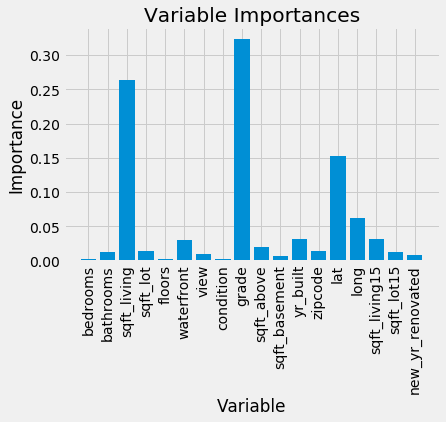

In [29]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

### Variable Importance (with crime)

In [28]:
# Get numerical feature importances
importances_w_crime = list(rf_2.feature_importances_)

# List of tuples with variable and importance
feature_importances_w_crime = [(feature, round(importance, 2)) for feature, importance in zip(feature_list_w_crime, importances_w_crime)]

# Sort the feature importances by most important first
feature_importances_w_crime = sorted(feature_importances_w_crime, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_w_crime];

Variable: grade                Importance: 0.32
Variable: sqft_living          Importance: 0.26
Variable: lat                  Importance: 0.15
Variable: long                 Importance: 0.06
Variable: waterfront           Importance: 0.03
Variable: yr_built             Importance: 0.03
Variable: sqft_living15        Importance: 0.03
Variable: sqft_above           Importance: 0.02
Variable: bathrooms            Importance: 0.01
Variable: sqft_lot             Importance: 0.01
Variable: view                 Importance: 0.01
Variable: sqft_basement        Importance: 0.01
Variable: zipcode              Importance: 0.01
Variable: sqft_lot15           Importance: 0.01
Variable: new_yr_renovated     Importance: 0.01
Variable: bedrooms             Importance: 0.0
Variable: floors               Importance: 0.0
Variable: condition            Importance: 0.0
Variable: no_of_crimes         Importance: 0.0


In [66]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices = [feature_list_w_crime.index('grade'), feature_list_w_crime.index('sqft_living'), feature_list_w_crime.index('lat')]
train_important = X_train_2[:, important_indices]
test_important = X_test_2[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, y_train_2)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - y_test_2)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2))
mape = np.mean(100 * (errors / y_test_2))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 109459.82
Accuracy: 81.1 %.


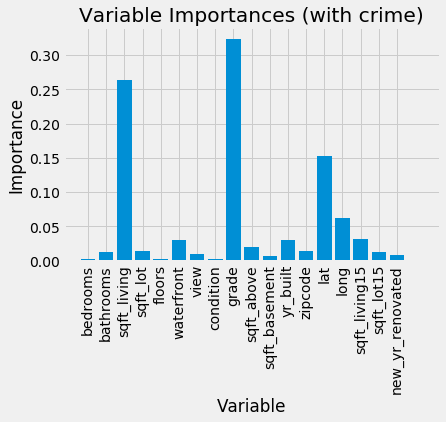

In [31]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values_w_crime = list(range(len(importances_w_crime)))
# Make a bar chart
plt.bar(x_values_w_crime, importances_w_crime, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list_w_crime, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances (with crime)');

In [40]:
# !pip install pydot
# !pip install graphviz

In [33]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

FileNotFoundError: [WinError 2] "dot" not found in path.

In [24]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(X_train, y_train)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

FileNotFoundError: [WinError 2] "dot" not found in path.